# Makemore: wavenet

- Bengio et al. 2003 MLP LM <https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf>
- WaveNet 2016 from DeepMind <https://arxiv.org/abs/1609.03499>
- <https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/>

## Reprise du réseau précédent

### Imports et configuration

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(42);
#torch.set_default_device('mps')
#torch.get_default_device()

### Lecture des données

In [3]:
class Words(object):

    def __init__(self, filename):
        if isinstance(filename, (list, tuple)):
            self.words = list()
            self.filename = list()
            for _fname in filename:
                self.filename.append(_fname)
                self._words = open(_fname, 'r').read().splitlines()
                self.words += self._words
            self.filename = ';'.join(self.filename)
            self.words = sorted(list(set(self.words)))
        else:
            self.filename = filename
            self.words = open(self.filename, 'r').read().splitlines()
        self.nb_words = len(self.words)
        self.chars = sorted(list(set(''.join(self.words))))
        self.nb_chars = len(self.chars) + 1  # On ajoute 1 pour EOS
        self.ctoi = {c:i+1 for i,c in enumerate(self.chars)}
        self.ctoi['.'] = 0
        self.itoc = {i:s for s,i in self.ctoi.items()}

    def __repr__(self):
        l = []
        l.append("<Words")
        l.append(f'  filename="{self.filename}"')
        l.append(f'  nb_words="{self.nb_words}"')
        l.append(f'  nb_chars="{self.nb_chars}"/>')
        return '\n'.join(l)

In [4]:
words = Words('civil_mots.txt')
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="civil_mots.txt"
  nb_words="7223"
  nb_chars="41"/>
["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
ctoi = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
itoc = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0:

In [5]:
words = Words('travail_mots.txt')
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="travail_mots.txt"
  nb_words="12105"
  nb_chars="42"/>
["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
ctoi = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, 'à': 29, 'â': 30, 'ç': 31, 'è': 32, 'é': 33, 'ê': 34, 'ë': 35, 'î': 36, 'ï': 37, 'ô': 38, 'ù': 39, 'û': 40, 'œ': 41, '.': 0}
itoc = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 29: 'à', 30: 'â', 31: 'ç', 32: 'è', 33: 'é', 34: 'ê', 35: 'ë', 36: 'î', 37: 'ï', 38: 'ô', 39:

In [6]:
words = Words(('civil_mots.txt','travail_mots.txt'))
print(words)
print(words.chars)
print("ctoi =", words.ctoi)
print("itoc =", words.itoc)

<Words
  filename="civil_mots.txt;travail_mots.txt"
  nb_words="14243"
  nb_chars="42"/>
["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
ctoi = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, 'à': 29, 'â': 30, 'ç': 31, 'è': 32, 'é': 33, 'ê': 34, 'ë': 35, 'î': 36, 'ï': 37, 'ô': 38, 'ù': 39, 'û': 40, 'œ': 41, '.': 0}
itoc = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 29: 'à', 30: 'â', 31: 'ç', 32: 'è', 33: 'é', 34: 'ê', 35: 'ë', 36: 'î', 37: 'ï

In [7]:
#words = Words('names.txt')
#print(words)
#print(words.chars)
#print("ctoi =", words.ctoi)
#print("itoc =", words.itoc)

### Dataset

In [8]:
def build_dataset(words:list, ctoi: dict, context_size:int):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        ctoi: mapping of character to int
        context_size: how many characters we take to predict the next one

    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    for w in words:
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [9]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

context_size = 3
Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

torch.Size([112462, 3]) torch.Size([112462])
torch.Size([14025, 3]) torch.Size([14025])
torch.Size([14046, 3]) torch.Size([14046])


In [10]:
for x,y in zip(Xtr[:30], Ytr[:30]):
  print(''.join(words.itoc[ix.item()] for ix in x), '-->', words.itoc[y.item()])

... --> h
..h --> o
.ho --> r
hor --> i
ori --> z
riz --> o
izo --> n
zon --> t
ont --> a
nta --> u
tau --> x
aux --> .
... --> c
..c --> h
.ch --> l
chl --> o
hlo --> r
lor --> u
oru --> r
rur --> e
ure --> .
... --> l
..l --> a
.la --> i
lai --> s
ais --> s
iss --> e
sse --> r
ser --> .
... --> p


### Classes

In [11]:
class Linear:
    """Linear layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.Linear.html>
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [12]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [13]:
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

### Hyperparamètres

In [14]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocab_size = words.nb_chars

### Réseau

In [15]:
C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    layers[-1].weight *= 0.1
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

15262


In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split, C, layers):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # N, context_size, n_embd
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

### Apprentissage

In [17]:
def train(X, Y, C, layers, max_steps, batch_size):
    lossi = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,))
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update: simple SGD
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    return lossi

In [18]:
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, C, layers, max_steps, batch_size)

      0/ 200000: 3.7218
  10000/ 200000: 1.7686
  20000/ 200000: 1.8990
  30000/ 200000: 2.1173
  40000/ 200000: 1.5305
  50000/ 200000: 1.5309
  60000/ 200000: 2.3511
  70000/ 200000: 1.7115
  80000/ 200000: 1.7289
  90000/ 200000: 2.3668
 100000/ 200000: 1.7856
 110000/ 200000: 2.0472
 120000/ 200000: 1.4615
 130000/ 200000: 1.7981
 140000/ 200000: 1.7360
 150000/ 200000: 1.4819
 160000/ 200000: 1.4111
 170000/ 200000: 1.7934
 180000/ 200000: 1.4151
 190000/ 200000: 1.6113


### Loss

In [19]:
split_loss('train', C, layers)
split_loss('dev', C, layers)

train 1.6371760368347168
dev 1.719710111618042


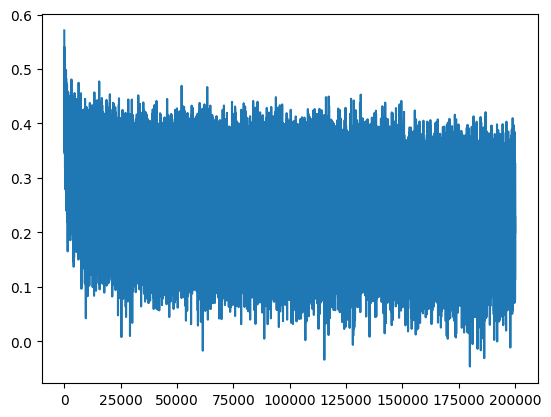

In [20]:
plt.plot(lossi);

In [21]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
torch.arange(10).view(2,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [23]:
torch.arange(10).view(5,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [24]:
torch.arange(10).view(5,-1)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [25]:
torch.arange(10).view(-1,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [26]:
torch.tensor(lossi)

tensor([0.5708, 0.5676, 0.5608,  ..., 0.1796, 0.2814, 0.2278])

In [27]:
torch.tensor(lossi).view(-1,1000)

tensor([[0.5708, 0.5676, 0.5608,  ..., 0.3782, 0.3224, 0.3676],
        [0.2791, 0.4059, 0.3513,  ..., 0.3725, 0.2965, 0.3417],
        [0.3391, 0.3535, 0.3028,  ..., 0.2643, 0.3127, 0.2976],
        ...,
        [0.0926, 0.3446, 0.1876,  ..., 0.2456, 0.2585, 0.2232],
        [0.2706, 0.3100, 0.1161,  ..., 0.2984, 0.2378, 0.2084],
        [0.1941, 0.2907, 0.2128,  ..., 0.1796, 0.2814, 0.2278]])

In [28]:
torch.tensor(lossi).view(-1,1000).shape

torch.Size([200, 1000])

In [29]:
torch.tensor(lossi).view(-1,1000).mean(1)

tensor([0.4044, 0.3523, 0.3350, 0.3250, 0.3171, 0.3100, 0.3047, 0.3018, 0.2985,
        0.2930, 0.2902, 0.2911, 0.2865, 0.2850, 0.2836, 0.2837, 0.2821, 0.2805,
        0.2790, 0.2753, 0.2736, 0.2735, 0.2716, 0.2718, 0.2709, 0.2715, 0.2671,
        0.2663, 0.2659, 0.2671, 0.2691, 0.2684, 0.2684, 0.2655, 0.2635, 0.2666,
        0.2650, 0.2617, 0.2606, 0.2620, 0.2674, 0.2623, 0.2594, 0.2635, 0.2611,
        0.2606, 0.2617, 0.2617, 0.2580, 0.2602, 0.2588, 0.2620, 0.2601, 0.2580,
        0.2600, 0.2577, 0.2596, 0.2596, 0.2585, 0.2591, 0.2582, 0.2564, 0.2564,
        0.2562, 0.2569, 0.2566, 0.2579, 0.2558, 0.2557, 0.2582, 0.2550, 0.2579,
        0.2550, 0.2547, 0.2530, 0.2565, 0.2533, 0.2543, 0.2527, 0.2572, 0.2545,
        0.2549, 0.2553, 0.2563, 0.2523, 0.2559, 0.2537, 0.2539, 0.2530, 0.2537,
        0.2572, 0.2526, 0.2536, 0.2537, 0.2543, 0.2538, 0.2548, 0.2524, 0.2540,
        0.2520, 0.2495, 0.2531, 0.2517, 0.2514, 0.2513, 0.2532, 0.2522, 0.2489,
        0.2504, 0.2517, 0.2510, 0.2538, 

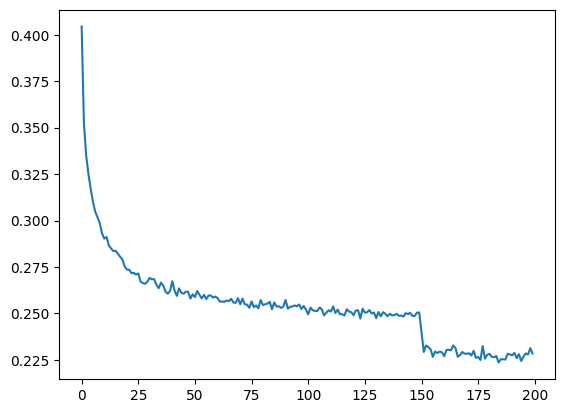

In [30]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

### Inférence

In [31]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for layer in layers:
    layer.training = False
for _ in range(20):
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        # if we sample the special '.' token, break
        if ix == 0:
            break
        else:
            out.append(ix)
    print(''.join(words.itoc[i] for i in out)) # decode and print the generated word

attoire
cours
aide
manche
révent
escrimé
ts-vents-prisent
imparmergier
incoptin
son
prent
codication
pris
émibles
délimines
télaffisante
ences-d'autélés
colluante-nie
injue
assion


## Amélioration de la structure du réseau (torchification)

L'objectif est de transfomer C en une vraie couche de notre réseau:

```python
C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(             n_hidden, vocab_size),
]
```

ainsi que la partie suivante de l'entraînement:

```python
# forward pass
emb = C[Xb] # embed the characters into vectors
x = emb.view(emb.shape[0], -1) # concatenate the vectors
```

In [32]:
class Embedding:
    """<https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html>"""
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

In [33]:
class Flatten:
    """<https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html>"""
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [34]:
torch.manual_seed(42);
layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    layers[-1].weight *= 0.1
parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

15262


In [35]:
def train(X, Y, C, layers, max_steps, batch_size):
    lossi = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,))
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        #emb = C[Xb] # embed the characters into vectors
        #x = emb.view(emb.shape[0], -1) # concatenate the vectors
        x = Xb
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update: simple SGD
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    return lossi

In [36]:
class Sequential:
    """<https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html>"""
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [37]:
torch.manual_seed(42);
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
])
with torch.no_grad():
    layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

15262


In [38]:
def train(X, Y, model, max_steps, batch_size):
    lossi = []
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, X.shape[0], (batch_size,))
        Xb, Yb = X[ix], Y[ix]
        
        # forward pass
        #x = Xb
        #for layer in layers:
        #    x = layer(x)
        #loss = F.cross_entropy(x, Yb) # loss function
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update: simple SGD
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in parameters:
            p.data += -lr * p.grad

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    return lossi

In [39]:
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, model, max_steps, batch_size)

      0/ 200000: 3.7498
  10000/ 200000: 1.8120
  20000/ 200000: 1.8656
  30000/ 200000: 2.1230
  40000/ 200000: 1.3996
  50000/ 200000: 1.5397
  60000/ 200000: 2.5345
  70000/ 200000: 1.7037
  80000/ 200000: 1.7236
  90000/ 200000: 2.3239
 100000/ 200000: 1.6762
 110000/ 200000: 1.9155
 120000/ 200000: 1.4189
 130000/ 200000: 1.8107
 140000/ 200000: 1.8771
 150000/ 200000: 1.4632
 160000/ 200000: 1.3078
 170000/ 200000: 1.7371
 180000/ 200000: 1.5394
 190000/ 200000: 1.5434


In [40]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split, model):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [41]:
split_loss('train', model)
split_loss('dev', model)

train 1.6353217363357544
dev 1.7146422863006592


In [42]:
def sample_model(n, model, g):
    # sample from the model
    for layer in model.layers:
        layer.training = False
    for _ in range(n):
        out = []
        context = [0] * context_size # initialize with all ...
        while True:
            # forward pass the neural net
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # shift the context window and track the samples
            context = context[1:] + [ix]
            # if we sample the special '.' token, break
            if ix == 0:
                break
            else:
                out.append(ix)
        print(''.join(words.itoc[i] for i in out)) # decode and print the generated word

In [43]:
g = torch.Generator().manual_seed(2147483647 + 9)
sample_model(20, model, g)

partora-effusuelle
acqueux
approvipuls
débarcomplent
configue
tournisterrovents
lé
ologiairesser
provait
cater
notantisse
progènes
déponistructif
orcé
bilitel
consident
mant
tromanière
réclins
prisations


## Contexte plus grand

In [44]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

context_size = 8
Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

torch.Size([112462, 8]) torch.Size([112462])
torch.Size([14025, 8]) torch.Size([14025])
torch.Size([14046, 8]) torch.Size([14046])


In [45]:
torch.manual_seed(42);
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * context_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
])
with torch.no_grad():
    layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

25262


In [46]:
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, model, max_steps, batch_size)

      0/ 200000: 4.0744
  10000/ 200000: 1.9363
  20000/ 200000: 2.0368
  30000/ 200000: 2.0350
  40000/ 200000: 2.0757
  50000/ 200000: 1.6367
  60000/ 200000: 1.2439
  70000/ 200000: 1.8216
  80000/ 200000: 2.0015
  90000/ 200000: 1.5378
 100000/ 200000: 1.4042
 110000/ 200000: 1.5082
 120000/ 200000: 1.6853
 130000/ 200000: 1.8711
 140000/ 200000: 1.3078
 150000/ 200000: 1.3572
 160000/ 200000: 1.7440
 170000/ 200000: 1.3852
 180000/ 200000: 1.5555
 190000/ 200000: 1.5828


In [47]:
split_loss('train', model)
split_loss('dev', model)

train 1.405772089958191
dev 1.6316717863082886


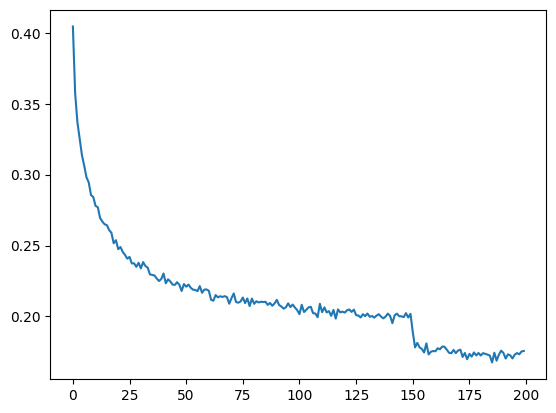

In [48]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [49]:
g = torch.Generator().manual_seed(2147483647 + 9)
sample_model(20, model, g)

particament
cumulais
lueu
contraint
sortis-juolisent
recflectées
collatére
ensonge
oldicié
chérectronaqion
territés
interdissements
bénéficteur
fondant
injoermene
incérier
subordonfape
déclinablement
persivera
autendisser


## Wavenet

In [50]:
### Comment implémenter wavenet ?

In [66]:
ix = torch.randint(0, Xtr.shape[0], (4,))  # Batch de 4 exemples
Xb = Xtr[ix]

In [52]:
Xb.shape

torch.Size([4, 8])

In [67]:
Xb

tensor([[ 0,  0,  3, 23, 24,  7, 16, 22],
        [ 0,  0,  0,  0, 11, 15, 18, 33],
        [ 3, 16,  3, 14, 27, 21,  7, 20],
        [ 0,  0, 15,  7, 16, 21, 23,  7]])

In [54]:
model.layers[0].out.shape  # Embedding layer

torch.Size([4, 8, 10])

In [55]:
model.layers[1].out.shape  # Flatten layer

torch.Size([4, 80])

In [62]:
model.layers[2].out.shape  # First Linear layer

torch.Size([4, 200])

In [64]:
(torch.randn(4,80) @ torch.randn(80,200)).shape

torch.Size([4, 200])

In [65]:
(torch.randn(4,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 200])

In [68]:
(torch.randn(4,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 200])

In [69]:
(torch.randn(4,5,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 5, 200])

In [70]:
(torch.randn(4,2,5,80) @ torch.randn(80,200)+torch.randn(200)).shape

torch.Size([4, 2, 5, 200])

In [78]:
# 0 1 2 3 4 5 6 7
# (0 1) (2 3) (4 5) (6 7)
# (a b) (c d)
# (e f)

In [73]:
(torch.randn(4,80) @ torch.randn(80,200)).shape

torch.Size([4, 200])

In [75]:
(torch.randn(4,4,20) @ torch.randn(20,200)).shape

torch.Size([4, 4, 200])

In [ ]:
# Passer de [4,8,10] à [4,4,20] où les 10-d vecteurs consécutifs sont concaténés

In [76]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [77]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [80]:
e = torch.randn(4, 8, 10)

In [82]:
explicit = torch.cat([e[:,::2,:], e[:,1::2,:]], dim=2)

In [83]:
explicit.shape

torch.Size([4, 4, 20])

In [84]:
e.view(4,4,20).shape

torch.Size([4, 4, 20])

In [86]:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [90]:
B = 4
T = 8
C = 10
e = torch.randn(B, T, C)
n = 2
e.view(B, T//n, C*n).shape

torch.Size([4, 4, 20])

In [93]:
B = 4
T = 2
C = 10
e = torch.randn(B, T, C)
n = 2
e = e.view(B, T//n, C*n)
e.shape

torch.Size([4, 1, 20])

In [95]:
e.squeeze(1).shape

torch.Size([4, 20])

In [87]:
# -> Reprendre Flatten, Linear et BatchNorm1d

### Nouvelles classes

In [105]:
class BatchNorm1d:
    """Batch normalization layer.
    
    Similar to <https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d>
    """
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [106]:
class FlattenConsecutive:
  
    def __init__(self, n): # n = 2
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape  # 4, 8, 10
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

In [107]:
vocab_size = words.nb_chars
# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

In [111]:
torch.set_default_device('mps')
torch.get_default_device()
# hierarchical network
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd   * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

78874


In [113]:
# 80%, 10%, 10%
import random
random.seed(42)
shuffled_words = words.words.copy()
random.shuffle(shuffled_words)
n1 = int(0.8*len(shuffled_words))
n2 = int(0.9*len(shuffled_words))

context_size = 8
Xtr, Ytr = build_dataset(shuffled_words[:n1], words.ctoi, context_size=context_size)
Xdev, Ydev = build_dataset(shuffled_words[n1:n2], words.ctoi, context_size=context_size)
Xte, Yte = build_dataset(shuffled_words[n2:], words.ctoi, context_size=context_size)

torch.Size([112462, 8]) torch.Size([112462])
torch.Size([14025, 8]) torch.Size([14025])
torch.Size([14046, 8]) torch.Size([14046])


In [114]:
max_steps = 200000
batch_size = 32
lossi = train(Xtr, Ytr, model, max_steps, batch_size)

      0/ 200000: 3.7493
  10000/ 200000: 2.0689
  20000/ 200000: 1.5539
  30000/ 200000: 1.6225
  40000/ 200000: 1.5611
  50000/ 200000: 1.1567
  60000/ 200000: 1.5405
  70000/ 200000: 1.5916
  80000/ 200000: 1.6781
  90000/ 200000: 1.1939
 100000/ 200000: 1.4520
 110000/ 200000: 1.6831
 120000/ 200000: 1.8349
 130000/ 200000: 1.5082
 140000/ 200000: 1.1232
 150000/ 200000: 0.8246
 160000/ 200000: 0.7312
 170000/ 200000: 1.2660
 180000/ 200000: 1.7399
 190000/ 200000: 0.6817


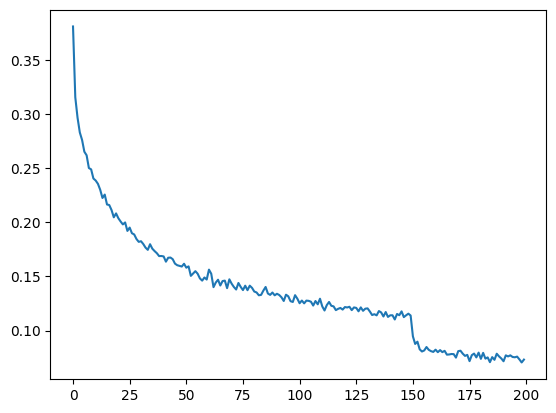

In [115]:
t_lossi = torch.tensor(lossi).cpu()
plt.plot(t_lossi.view(-1, 1000).mean(1))

In [116]:
split_loss('train', model)
split_loss('dev', model)

train 1.1275218725204468
dev 1.4990410804748535


In [118]:
g = torch.Generator(device='mps').manual_seed(2147483647 + 9)
sample_model(20, model, g)

doparte
amionnariage
détourne
quadrer
réformer
somptable
variantes
maximulativés
sualisée
médides
branches
statution
émanimés
compensatrice
séries
agent
fidences
reque
rembours
libérer
